## Pumpkin Pricing

Load up required libraries and dataset. Convert the data to a dataframe containing a subset of the data: 

- Only get pumpkins priced by the bushel
- Convert the date to a month
- Calculate the price to be an average of high and low prices
- Convert the price to reflect the pricing by bushel quantity

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pumpkins = pd.read_csv('US-pumpkins.csv')

pumpkins.head()


,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,Mostly High,Origin,Origin District,Item Size,Color,Environment,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,280.0,MARYLAND,NaN,lge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,280.0,MARYLAND,NaN,lge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,160.0,DELAWARE,NaN,med,ORANGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,160.0,VIRGINIA,NaN,med,ORANGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,100.0,MARYLAND,NaN,lge,ORANGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [ ]:

pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date', 'City Num', 'Variety Num']


pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month


new_pumpkins = pd.DataFrame({'Month': month, 'Variety': pumpkins['Variety'], 'City': pumpkins['City Name'], 'Package': pumpkins['Package'], 'Low Price': pumpkins['Low Price'],'High Price': pumpkins['High Price'], 'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


,Month,Variety,City,Package,Low Price,High Price,Price
70,9,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364
71,9,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
72,10,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
73,10,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,15.454545
74,10,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364


A basic scatterplot reminds us that we only have month data from August through December. We probably need more data to be able to draw conclusions in a linear fashion.

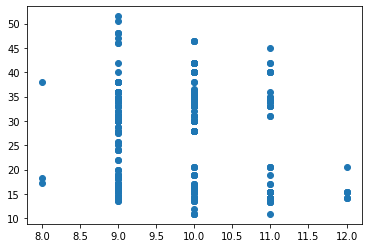

In [ ]:
import matplotlib.pyplot as plt
plt.scatter('Month','Price',data=new_pumpkins)

Now, we process labels in data to analyze relations between features. We calculate correlations to select features to make predictions

In [ ]:
from sklearn.preprocessing import LabelEncoder
new_pumpkins.iloc[:,0:-1] = new_pumpkins.iloc[:,0:-1].apply(LabelEncoder().fit_transform)

In [ ]:
print(new_pumpkins["City"].corr(new_pumpkins["Price"]))

0.3236397181608923


In [ ]:
print(new_pumpkins["Package"].corr(new_pumpkins["Price"]))

0.6061712937226016


In [ ]:
#remove NA values
new_pumpkins.dropna(inplace=True)
new_pumpkins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 70 to 1742
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       415 non-null    int64  
 1   Variety     415 non-null    int64  
 2   City        415 non-null    int64  
 3   Package     415 non-null    int64  
 4   Low Price   415 non-null    int64  
 5   High Price  415 non-null    int64  
 6   Price       415 non-null    float64
dtypes: float64(1), int64(6)
memory usage: 25.9 KB


Select features with higher correlation to make regresssion and fit a model

In [ ]:
new_columns = ["Package", "Price"]
lin_pumpkins = new_pumpkins.drop([c for c in new_pumpkins.columns if c not in new_columns], axis = "columns")
lin_pumpkins

,Package,Price
70,0,13.636364
71,0,16.363636
72,0,16.363636
73,0,15.454545
74,0,13.636364
...,...,...
1738,2,30.000000
1739,2,28.750000
1740,2,25.750000
1741,2,24.000000


In [ ]:
X = lin_pumpkins.values[:,:1]
y = lin_pumpkins.values[:,1:2]

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size = 0.2, random_state = 0)

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)
print(f"model acc: {lin_reg.score(X_test, y_test)}")


model acc: 0.46811022082785075


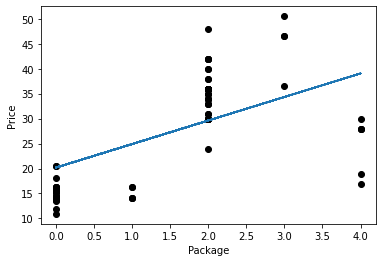

In [ ]:
plt.scatter(X_test, y_test, color = "black")
plt.plot(X_test, pred)

plt.xlabel("Package")
plt.ylabel("Price")
_ = plt.show()

##Polynomial regresion

In [ ]:
new_columns = ["Variety", "Package", "City", "Month", "Price"]

poly_pumpkins = new_pumpkins.drop([c for c in new_pumpkins.columns if c not in new_columns], axis = 1)
poly_pumpkins

,Month,Variety,City,Package,Price
70,1,3,1,0,13.636364
71,1,3,1,0,16.363636
72,2,3,1,0,16.363636
73,2,3,1,0,15.454545
74,2,3,1,0,13.636364
...,...,...,...,...,...
1738,1,1,9,2,30.000000
1739,1,1,9,2,28.750000
1740,1,1,9,2,25.750000
1741,1,1,9,2,24.000000


In [ ]:
corr = poly_pumpkins.corr()
corr.style.background_gradient(cmap = "coolwarm")

,Month,Variety,City,Package,Price
Month,1.000000,0.171330,-0.188728,-0.144847,-0.148783
Variety,0.171330,1.000000,-0.248441,-0.614855,-0.863479
City,-0.188728,-0.248441,1.000000,0.301604,0.323640
Package,-0.144847,-0.614855,0.301604,1.000000,0.606171
Price,-0.148783,-0.863479,0.323640,0.606171,1.000000


In [ ]:
#X: package
#y: prices
X = poly_pumpkins.iloc[:,3:4].values
y = poly_pumpkins.iloc[:,4:5].values

In [ ]:
from sklearn.preprocessing import  PolynomialFeatures
from sklearn.pipeline import make_pipeline
#We adjust a 4th degree polynomial function
pipeline = make_pipeline(PolynomialFeatures(4), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

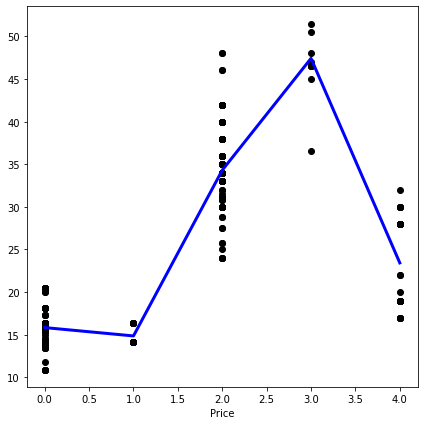

In [ ]:
df = pd.DataFrame({"x":X_test[:,0], "y": y_pred[:,0]})
df.sort_values(by = "x", inplace = True)

points = df.to_numpy()
plt.figure(figsize=(7,7))
plt.plot(points[:,0], points[:,1], color = "blue", linewidth = 3)
plt.xlabel("Package")
plt.xlabel("Price")
plt.scatter(X, y, color= "black")
_ = plt.show()

In [ ]:
print(f"model acc: {pipeline.score(X_test, y_test)}")

model acc: 0.8744883218018484


In [ ]:
print(f"prediction for: {2.75}")
print(f"{pipeline.predict(np.array([[2.75]]))}")

prediction for: 2.75
[[46.34509342]]
